In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv

In [85]:
GaussValueArray = GaussValueArray = [0.643, 1.210, 1.815, 2.440]
sigma_IH = 1 #PLACEHOLDER
sigma_Vh = 0.1 #PLACEHOLDER
Zed = 0.45 #Placeholder coefficant used in Vh = R/z * IH
delta_Zed = 0.05

In [14]:
def model(a, IH):
    return a[0] * IH #Where gradient) (a) is R/Z

In [15]:
def read_data(filename):
    with open(filename, newline='') as csvfile:
        file_data = list(csv.reader(csvfile))
    return file_data

In [36]:
#Takes data, sorts into items required for graph
def data_sort(file_data, GaussValueArray):
    IH = []
    Vh = []
    for item in file_data:#Sorting the values of magnetic filed strength in Gauss and Current to find IH
        if item[1] == "0.5":
            IH.append(float(GaussValueArray[0]) * float(item[2]))
        elif item[1] == "1":
            IH.append(float(GaussValueArray[1]) * float(item[2]))
        elif item[1] == "1.5":
            IH.append(float(GaussValueArray[2]) * float(item[2]))
        elif item[1] == "2":
            IH.append(float(GaussValueArray[3]) * float(item[2]))
        else:
            raise ValueError("Current of electromagnet doesn't equal 0.5, 1, 1.5, 2")
    for item in file_data:#Sorting voltage - z potential
        Vh.append(float(item[3]) - float(item[0].strip('\ufeff')))
        
    n = len(IH)
    
    return IH, Vh, n

In [22]:
def find_coefficients(n, IH, Vh, sigma_Vh):
    bf = np.zeros((1, n)) # Define an empty basis function matrix
    bf[0,:] = IH # Only one basis function required, refer to def(model)
    
    # Empty matrices for Ax=b equation
    A = np.zeros((1, 1))
    b = np.zeros(1)
    
    # Populating A and b with v^2 and its uncertainty
    for k in range(1):
        for j in range(1):
            A[k,j] = np.sum(bf[k,:] * bf[j,:] / sigma_Vh**2)
        b[k] = np.sum(Vh * bf[k,:] / sigma_Vh**2)

    return np.linalg.solve(A, b)

In [72]:
def plot_graph(IH, Vh, sigma_Vh, a, title):
    xx = np.linspace(min(IH), max(IH), 1000) # Calculate values for model
    
    # Initiate and plot graph
    plt.figure()
    plt.errorbar(IH, Vh, sigma_Vh, fmt='.')
    plt.plot(xx, model(a, xx),'r-')
    plt.title(title)
    plt.xlabel('IH')
    plt.ylabel('Vh')
    
    delta_y = model(a, xx)[-1] - model(a, xx)[0] #Finding gradient by the classic rise over run method
    delta_x = xx[-1] - xx[0]
    gradient = delta_y / delta_x

    return gradient

In [19]:
def calculate_R(a):
    R = Zed * a[0]
    sigma_slope = np.sqrt(1/a[0])
    sigma_R = R * (sigma_slope / a[0])

    return R, sigma_R

In [135]:
def plotting(FILENAME, title):
    ndata_pos = read_data(FILENAME)
    
    IH, Vh, n = data_sort(ndata_pos, GaussValueArray)
    
    a = find_coefficients(n, IH, Vh, sigma_Vh)
    
    gradient = plot_graph(IH, Vh, sigma_Vh, a, title)
    
    R = gradient * Zed
    delta_k = 1 ###PLACEHOLDER###
    uncertainty = find_uncertainty(gradient, Zed, delta_Zed, delta_k)
    d_v, dv_uncertainty = drift_velocity(R, uncertainty)
    print("Hall Coefficient is equal to:", R, "m^3 / A-sec")
    print("With Uncertainty of:", u"\u00B1", uncertainty)
    print("And a relative drift velocity of:", d_v, u"\u00B1", dv_uncertainty)
    print(" ")
    

In [133]:
def find_uncertainty(K, Z, delta_Z, delta_K):
    delta_R = np.sqrt((Z**2 * delta_K**2) + (K**2 * delta_Z**2)) * (K * Z)
    return delta_R

In [142]:
def drift_velocity(hall_coefficient, delta_R):
    elementary_charge = 1.60217662e-19
    Cd_Copper = 8.5e28
    Cd = 1 / (hall_coefficient * elementary_charge)
    drift_velocity = abs(Cd_Copper / Cd)
    dv_uncertainty = Cd_Copper * elementary_charge * delta_R
    return "%.4g" % drift_velocity, "%.4g" % dv_uncertainty

Hall Coefficient is equal to: 3.643979667799953 m^3 / A-sec
With Uncertainty of: ± 2.2058366212812546
And a relative drift velocity of: 4.963e+10 ± 3.004e+10
 
Hall Coefficient is equal to: -3.6734439787896402 m^3 / A-sec
With Uncertainty of: ± -2.2317342094149404
And a relative drift velocity of: 5.003e+10 ± -3.039e+10
 
Hall Coefficient is equal to: 1.7846148158908883 m^3 / A-sec
With Uncertainty of: ± 0.8775862841991716
And a relative drift velocity of: 2.43e+10 ± 1.195e+10
 
Hall Coefficient is equal to: -2.18961546820808 m^3 / A-sec
With Uncertainty of: ± -1.1201125967759722
And a relative drift velocity of: 2.982e+10 ± -1.525e+10
 


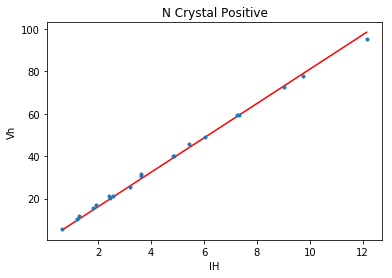

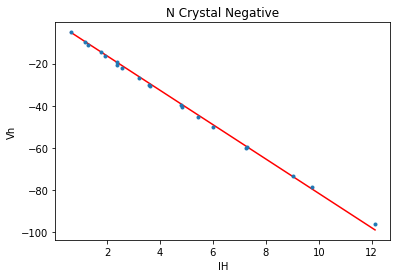

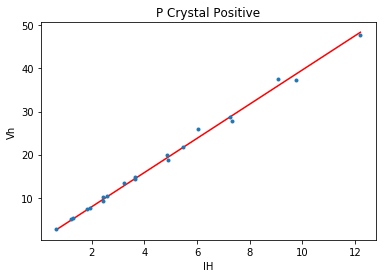

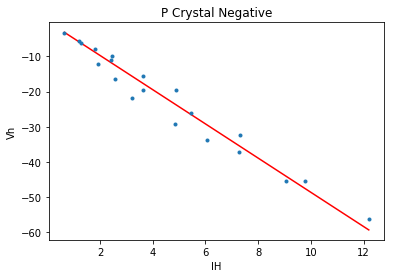

In [143]:
plotting('ncrystal pos.csv', 'N Crystal Positive')
plotting('ncrystal neg.csv', 'N Crystal Negative')
plotting('pcrystal pos.csv', 'P Crystal Positive')
plotting('pcrystal neg.csv', 'P Crystal Negative')